# Single transit search

In this notebook, we use `nuance` to search for a single transit.

In [1]:
# in order to run on all CPUs
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## Generating the data

Let's generate some data first, of a unique planetary transit lost in a smooth stellar variability signal

In [2]:
import numpy as np
from tinygp import kernels, GaussianProcess
from nuance import core

depth = 1e-3
error = 0.5e-3
time = np.linspace(0, 1, 2000)
transit_prams = {"epoch": 0.3, "duration": 0.05, "period": 10}
transit_model = depth * core.transit(time, **transit_prams)
kernel = kernels.quasisep.SHO(10.0, 200.0, 0.005)
gp = GaussianProcess(kernel, time, diag=error**2)

flux = transit_model + gp.sample(jax.random.PRNGKey(0)) + 1.0

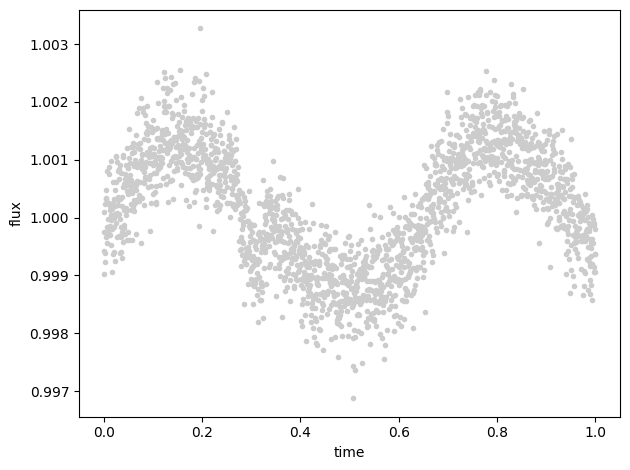

In [3]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, xlabel="time", ylabel="flux")
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

## The *linear search*

We can now look for single transit events by performing the [`linear_search`](nuance.linear_search) over all times (considered as potential transit epochs) and on a wide range of durations.

In [4]:
from nuance.linear_search import linear_search

epochs = time.copy()
durations = np.linspace(0.01, 0.2, 15)

ls_function = linear_search(time, flux, gp=gp)
lls, depths, vars = ls_function(epochs, durations)

100%|██████████| 2004/2004 [00:00<00:00, 4531.61it/s]


```{important}
*nuance* relies on [tinygp](https://tinygp.readthedocs.io) to manipulate Gaussian processes. Although `gp` in the previous cell is already a [`tinygp.GaussianProcess`](https://tinygp.readthedocs.io/en/latest/api/summary/tinygp.GaussianProcess.html) instance (from the simulated data), in practice one has to build their own.
```

To have an idea of where the potential candidates might be, let's plot the unique transit log-likelihood computed during the linear search.

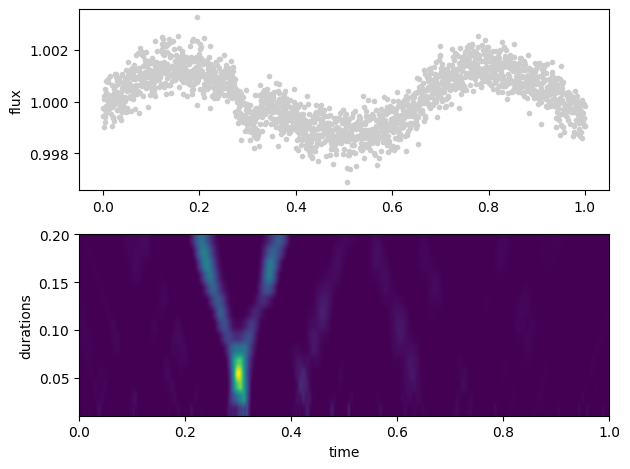

In [5]:
plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")

plt.subplot(212)
plt.imshow(
    lls.T,
    aspect="auto",
    origin="lower",
    extent=[time.min(), time.max(), durations.min(), durations.max()],
)
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

We clearly identify a transit candidate

In [6]:
i, duration_i = np.unravel_index(np.argmax(lls), lls.shape)
t0, D = epochs[i], durations[duration_i]

print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration"], [t0, D])]))

epoch: 0.301
duration: 0.051


that we can plot thanks to its parameters

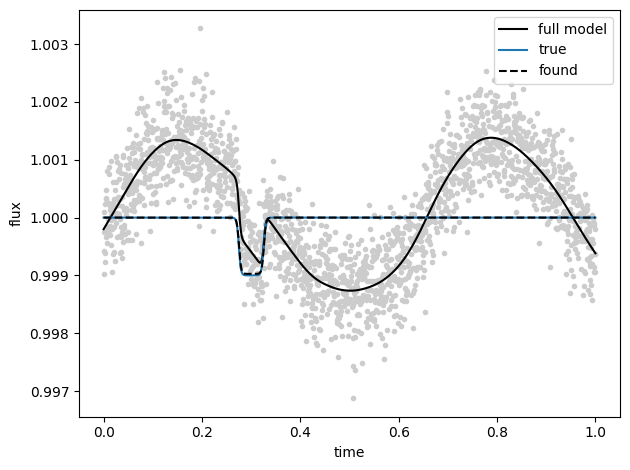

In [7]:
linear, astro, noise = core.separate_models(time, flux, gp=gp)(t0, D)

plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + astro + noise, c="k", label="full model")
plt.plot(time, transit_model + 1, ls="-", c="C0", label="true")
plt.plot(time, astro + 1.0, ls="--", c="k", label="found")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

Which is the one injected in the simulated dataset